In [1]:
import numpy as np 
import time

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler
import os
os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Repos\InceptionTime-Pytorch-master')
import pandas as pd

from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import json

import matplotlib.pyplot as plt

In [2]:
from inception import Inception, InceptionBlock

In [3]:
class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
	def __init__(self, out_shape):
		super(Reshape, self).__init__()
		self.out_shape = out_shape

	def forward(self, x):
		return x.view(-1, *self.out_shape)

In [77]:
path=r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data'
os.chdir(path)
filename_labels='Labelled_Data_Onset_18-25thFeb'
filename_data='Labelling_Data_Onset_18-25thFeb'
labels=pd.read_csv(filename_labels+'.csv')
labels=pd.DataFrame(json.loads(labels['label'][0]))[['start','timeserieslabels']]
data=pd.read_csv(filename_data+'.csv',nrows=labels['start'].iloc[-1]+500)
data['label']=''
for ind,lab in zip(labels['start'],labels['timeserieslabels']):
    data.loc[(data.index>=ind-2) & (data.index<=ind+5),'label']=lab[0]
data['logged_time_local']=pd.to_datetime(data['logged_time_local'])
# data=data.set_index('logged_time_local').sort_index()

LOOK_BACK = 7
def create_dataset (X, look_back = 7):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = data['mains_power'][i:i+look_back].values
        Xs.append(v)
        ys.append(dummy_y[i+look_back])
 
    return np.array(Xs).reshape(len(Xs), look_back, 1), np.array(ys)

# encode and transform labels 
encoder = LabelEncoder()
encoder.fit(data['label'])
encoded_Y = encoder.transform(data['label'])

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

X_train, y_train = create_dataset(data,LOOK_BACK)
# X_train_back, y_train_back = X_train, y_train
# X_train, y_train = create_dataset(data.loc[data.reset_index().index.isin(pd.Index(lis))],LOOK_BACK)

In [78]:
lis=list(data[data['label']!=''].index)+list(np.arange(0,2000,1))
xtrain=[]
ytrain=[]
for i in lis:
    xtrain.append(X_train_back[i])
    ytrain.append(y_train_back[i])
    
X_train=np.array(xtrain)
y_train=np.array(ytrain)

In [79]:
pd.DataFrame(y_train).sum()
# data.reset_index()[data.reset_index()['label']!=''].pivot_table(index='label', aggfunc='count')

0    3468.0
1     114.0
2     114.0
dtype: float32

In [80]:
# X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
#                np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
# y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [81]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ValueError: Found array with dim 3. RobustScaler expected <= 2.

In [11]:
InceptionTime = nn.Sequential(
                    Reshape(out_shape=(1,7)),
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=3)
        )

In [48]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

dataset = TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = DataLoader(dataset,batch_size=32) # create your dataloader


In [31]:
# InceptionTime.load_state_dict(torch.load("InceptionTime_full-version_lr-{5e-3,1e-3,2e-4},_bs-512_ks-[5,11,23]_100-epochs_state_dict.pt"))

In [49]:
net=InceptionTime
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for epoch in range(epochs):
#     for inputs, labels in trainloader:
#         inputs, labels = inputs.to(device), labels.to(device)

net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

[1,     1] loss: 25.743
[1,     2] loss: 5.574
[1,     3] loss: 1.248
[1,     4] loss: 2.994
[1,     5] loss: 0.022
[1,     6] loss: 112.204
[1,     7] loss: 4.630
[1,     8] loss: 16.998
[1,     9] loss: 7.734
[1,    10] loss: 1.976
[1,    11] loss: 1.806
[1,    12] loss: 3.824
[1,    13] loss: 1.777
[1,    14] loss: 4.094
[1,    15] loss: 1.034
[1,    16] loss: 1.167
[1,    17] loss: 1.588
[1,    18] loss: 1.142
[1,    19] loss: 6.304
[1,    20] loss: 0.999
[1,    21] loss: 0.533
[1,    22] loss: 0.816
[1,    23] loss: 0.488
[1,    24] loss: 0.450
[1,    25] loss: 1.040
[1,    26] loss: 0.644
[1,    27] loss: 0.227
[1,    28] loss: 0.095
[1,    29] loss: 0.475
[1,    30] loss: 0.184
[1,    31] loss: 0.915
[1,    32] loss: 2.413
[1,    33] loss: 17.688
[1,    34] loss: 0.514
[1,    35] loss: 15.247
[1,    36] loss: 0.602
[1,    37] loss: 0.631
[1,    38] loss: 0.731
[1,    39] loss: 1.748
[1,    40] loss: 2.069
[1,    41] loss: 2.356
[1,    42] loss: 2.182
[1,    43] loss: 1.842
[1,  

[4,    15] loss: 0.123
[4,    16] loss: 0.157
[4,    17] loss: 0.299
[4,    18] loss: 0.084
[4,    19] loss: 0.441
[4,    20] loss: 0.060
[4,    21] loss: 0.110
[4,    22] loss: 0.091
[4,    23] loss: 0.050
[4,    24] loss: 0.051
[4,    25] loss: 0.271
[4,    26] loss: 0.126
[4,    27] loss: 0.108
[4,    28] loss: 0.062
[4,    29] loss: 0.069
[4,    30] loss: 0.062
[4,    31] loss: 0.105
[4,    32] loss: 0.169
[4,    33] loss: 0.381
[4,    34] loss: 0.080
[4,    35] loss: 0.307
[4,    36] loss: 0.192
[4,    37] loss: 0.309
[4,    38] loss: 0.096
[4,    39] loss: 0.300
[4,    40] loss: 0.212
[4,    41] loss: 0.635
[4,    42] loss: 0.096
[4,    43] loss: 0.085
[4,    44] loss: 0.081
[4,    45] loss: 0.168
[4,    46] loss: 0.072
[4,    47] loss: 0.843
[4,    48] loss: 0.818
[4,    49] loss: 0.249
[4,    50] loss: 0.084
[4,    51] loss: 0.938
[4,    52] loss: 0.087
[4,    53] loss: 0.164
[4,    54] loss: 0.000
[4,    55] loss: 0.000
[4,    56] loss: 0.000
[4,    57] loss: 0.000
[4,    58] 

[7,    32] loss: 0.242
[7,    33] loss: 0.142
[7,    34] loss: 0.093
[7,    35] loss: 0.599
[7,    36] loss: 0.215
[7,    37] loss: 0.318
[7,    38] loss: 0.102
[7,    39] loss: 0.328
[7,    40] loss: 0.247
[7,    41] loss: 0.597
[7,    42] loss: 0.109
[7,    43] loss: 0.087
[7,    44] loss: 0.083
[7,    45] loss: 0.133
[7,    46] loss: 0.079
[7,    47] loss: 1.107
[7,    48] loss: 1.041
[7,    49] loss: 0.198
[7,    50] loss: 0.096
[7,    51] loss: 1.012
[7,    52] loss: 0.085
[7,    53] loss: 0.148
[7,    54] loss: 0.001
[7,    55] loss: 0.001
[7,    56] loss: 0.000
[7,    57] loss: 0.000
[7,    58] loss: 0.000
[7,    59] loss: 0.000
[7,    60] loss: 0.000
[7,    61] loss: 0.000
[7,    62] loss: 0.000
[7,    63] loss: 0.000
[7,    64] loss: 0.000
[7,    65] loss: 0.000
[7,    66] loss: 0.000
[7,    67] loss: 0.000
[7,    68] loss: 0.000
[7,    69] loss: 0.000
[7,    70] loss: 0.000
[7,    71] loss: 0.000
[7,    72] loss: 0.000
[7,    73] loss: 0.000
[7,    74] loss: 0.000
[7,    75] 

[10,    41] loss: 0.416
[10,    42] loss: 0.078
[10,    43] loss: 0.058
[10,    44] loss: 0.162
[10,    45] loss: 0.109
[10,    46] loss: 0.056
[10,    47] loss: 0.604
[10,    48] loss: 0.514
[10,    49] loss: 0.193
[10,    50] loss: 0.076
[10,    51] loss: 0.825
[10,    52] loss: 0.070
[10,    53] loss: 0.144
[10,    54] loss: 0.001
[10,    55] loss: 0.001
[10,    56] loss: 0.001
[10,    57] loss: 0.001
[10,    58] loss: 0.001
[10,    59] loss: 0.001
[10,    60] loss: 0.001
[10,    61] loss: 0.001
[10,    62] loss: 0.001
[10,    63] loss: 0.001
[10,    64] loss: 0.001
[10,    65] loss: 0.001
[10,    66] loss: 0.001
[10,    67] loss: 0.001
[10,    68] loss: 0.001
[10,    69] loss: 0.001
[10,    70] loss: 0.001
[10,    71] loss: 0.001
[10,    72] loss: 0.001
[10,    73] loss: 0.001
[10,    74] loss: 0.001
[10,    75] loss: 0.000
[10,    76] loss: 0.000
[10,    77] loss: 0.000
[10,    78] loss: 0.000
[10,    79] loss: 0.000
[10,    80] loss: 0.000
[10,    81] loss: 0.000
[10,    82] loss

[13,    39] loss: 0.111
[13,    40] loss: 0.076
[13,    41] loss: 0.620
[13,    42] loss: 0.074
[13,    43] loss: 0.067
[13,    44] loss: 0.115
[13,    45] loss: 0.116
[13,    46] loss: 0.056
[13,    47] loss: 1.405
[13,    48] loss: 1.327
[13,    49] loss: 0.155
[13,    50] loss: 0.063
[13,    51] loss: 1.060
[13,    52] loss: 0.080
[13,    53] loss: 0.071
[13,    54] loss: 0.009
[13,    55] loss: 0.009
[13,    56] loss: 0.008
[13,    57] loss: 0.007
[13,    58] loss: 0.006
[13,    59] loss: 0.005
[13,    60] loss: 0.004
[13,    61] loss: 0.004
[13,    62] loss: 0.003
[13,    63] loss: 0.003
[13,    64] loss: 0.002
[13,    65] loss: 0.002
[13,    66] loss: 0.002
[13,    67] loss: 0.002
[13,    68] loss: 0.001
[13,    69] loss: 0.001
[13,    70] loss: 0.001
[13,    71] loss: 0.001
[13,    72] loss: 0.001
[13,    73] loss: 0.001
[13,    74] loss: 0.001
[13,    75] loss: 0.001
[13,    76] loss: 0.001
[13,    77] loss: 0.001
[13,    78] loss: 0.001
[13,    79] loss: 0.001
[13,    80] loss

[16,    38] loss: 0.078
[16,    39] loss: 0.102
[16,    40] loss: 0.098
[16,    41] loss: 0.178
[16,    42] loss: 0.065
[16,    43] loss: 0.048
[16,    44] loss: 0.142
[16,    45] loss: 0.098
[16,    46] loss: 0.049
[16,    47] loss: 0.639
[16,    48] loss: 0.541
[16,    49] loss: 0.131
[16,    50] loss: 0.061
[16,    51] loss: 0.719
[16,    52] loss: 0.101
[16,    53] loss: 0.059
[16,    54] loss: 0.006
[16,    55] loss: 0.006
[16,    56] loss: 0.006
[16,    57] loss: 0.005
[16,    58] loss: 0.005
[16,    59] loss: 0.004
[16,    60] loss: 0.004
[16,    61] loss: 0.003
[16,    62] loss: 0.003
[16,    63] loss: 0.003
[16,    64] loss: 0.002
[16,    65] loss: 0.002
[16,    66] loss: 0.002
[16,    67] loss: 0.002
[16,    68] loss: 0.001
[16,    69] loss: 0.001
[16,    70] loss: 0.001
[16,    71] loss: 0.001
[16,    72] loss: 0.001
[16,    73] loss: 0.001
[16,    74] loss: 0.001
[16,    75] loss: 0.001
[16,    76] loss: 0.001
[16,    77] loss: 0.001
[16,    78] loss: 0.001
[16,    79] loss

[19,    34] loss: 0.077
[19,    35] loss: 0.468
[19,    36] loss: 0.215
[19,    37] loss: 0.200
[19,    38] loss: 0.092
[19,    39] loss: 0.218
[19,    40] loss: 0.172
[19,    41] loss: 0.437
[19,    42] loss: 0.103
[19,    43] loss: 0.082
[19,    44] loss: 0.079
[19,    45] loss: 0.102
[19,    46] loss: 0.065
[19,    47] loss: 1.342
[19,    48] loss: 1.291
[19,    49] loss: 0.141
[19,    50] loss: 0.093
[19,    51] loss: 1.284
[19,    52] loss: 0.090
[19,    53] loss: 0.089
[19,    54] loss: 0.004
[19,    55] loss: 0.004
[19,    56] loss: 0.004
[19,    57] loss: 0.004
[19,    58] loss: 0.003
[19,    59] loss: 0.003
[19,    60] loss: 0.003
[19,    61] loss: 0.002
[19,    62] loss: 0.002
[19,    63] loss: 0.002
[19,    64] loss: 0.002
[19,    65] loss: 0.002
[19,    66] loss: 0.002
[19,    67] loss: 0.001
[19,    68] loss: 0.001
[19,    69] loss: 0.001
[19,    70] loss: 0.001
[19,    71] loss: 0.001
[19,    72] loss: 0.001
[19,    73] loss: 0.001
[19,    74] loss: 0.001
[19,    75] loss

[22,    33] loss: 0.132
[22,    34] loss: 0.077
[22,    35] loss: 0.191
[22,    36] loss: 0.212
[22,    37] loss: 0.169
[22,    38] loss: 0.090
[22,    39] loss: 0.117
[22,    40] loss: 0.098
[22,    41] loss: 0.232
[22,    42] loss: 0.074
[22,    43] loss: 0.059
[22,    44] loss: 0.144
[22,    45] loss: 0.106
[22,    46] loss: 0.049
[22,    47] loss: 0.488
[22,    48] loss: 0.495
[22,    49] loss: 0.104
[22,    50] loss: 0.056
[22,    51] loss: 0.682
[22,    52] loss: 0.088
[22,    53] loss: 0.093
[22,    54] loss: 0.006
[22,    55] loss: 0.005
[22,    56] loss: 0.005
[22,    57] loss: 0.004
[22,    58] loss: 0.004
[22,    59] loss: 0.003
[22,    60] loss: 0.003
[22,    61] loss: 0.003
[22,    62] loss: 0.002
[22,    63] loss: 0.002
[22,    64] loss: 0.002
[22,    65] loss: 0.002
[22,    66] loss: 0.002
[22,    67] loss: 0.001
[22,    68] loss: 0.001
[22,    69] loss: 0.001
[22,    70] loss: 0.001
[22,    71] loss: 0.001
[22,    72] loss: 0.001
[22,    73] loss: 0.001
[22,    74] loss

[25,    36] loss: 0.210
[25,    37] loss: 0.156
[25,    38] loss: 0.075
[25,    39] loss: 0.091
[25,    40] loss: 0.073
[25,    41] loss: 0.139
[25,    42] loss: 0.064
[25,    43] loss: 0.042
[25,    44] loss: 0.145
[25,    45] loss: 0.091
[25,    46] loss: 0.044
[25,    47] loss: 0.281
[25,    48] loss: 0.309
[25,    49] loss: 0.127
[25,    50] loss: 0.046
[25,    51] loss: 0.620
[25,    52] loss: 0.098
[25,    53] loss: 0.058
[25,    54] loss: 0.006
[25,    55] loss: 0.006
[25,    56] loss: 0.005
[25,    57] loss: 0.005
[25,    58] loss: 0.005
[25,    59] loss: 0.004
[25,    60] loss: 0.004
[25,    61] loss: 0.004
[25,    62] loss: 0.003
[25,    63] loss: 0.003
[25,    64] loss: 0.003
[25,    65] loss: 0.003
[25,    66] loss: 0.002
[25,    67] loss: 0.002
[25,    68] loss: 0.002
[25,    69] loss: 0.002
[25,    70] loss: 0.002
[25,    71] loss: 0.002
[25,    72] loss: 0.001
[25,    73] loss: 0.001
[25,    74] loss: 0.001
[25,    75] loss: 0.001
[25,    76] loss: 0.001
[25,    77] loss

[28,    37] loss: 0.165
[28,    38] loss: 0.087
[28,    39] loss: 0.097
[28,    40] loss: 0.082
[28,    41] loss: 0.102
[28,    42] loss: 0.066
[28,    43] loss: 0.043
[28,    44] loss: 0.137
[28,    45] loss: 0.089
[28,    46] loss: 0.036
[28,    47] loss: 0.172
[28,    48] loss: 0.204
[28,    49] loss: 0.114
[28,    50] loss: 0.043
[28,    51] loss: 0.531
[28,    52] loss: 0.109
[28,    53] loss: 0.051
[28,    54] loss: 0.005
[28,    55] loss: 0.005
[28,    56] loss: 0.005
[28,    57] loss: 0.005
[28,    58] loss: 0.004
[28,    59] loss: 0.004
[28,    60] loss: 0.004
[28,    61] loss: 0.003
[28,    62] loss: 0.003
[28,    63] loss: 0.003
[28,    64] loss: 0.003
[28,    65] loss: 0.002
[28,    66] loss: 0.002
[28,    67] loss: 0.002
[28,    68] loss: 0.002
[28,    69] loss: 0.002
[28,    70] loss: 0.002
[28,    71] loss: 0.002
[28,    72] loss: 0.001
[28,    73] loss: 0.001
[28,    74] loss: 0.001
[28,    75] loss: 0.001
[28,    76] loss: 0.001
[28,    77] loss: 0.001
[28,    78] loss

[31,    42] loss: 0.066
[31,    43] loss: 0.049
[31,    44] loss: 0.153
[31,    45] loss: 0.095
[31,    46] loss: 0.041
[31,    47] loss: 0.278
[31,    48] loss: 0.307
[31,    49] loss: 0.116
[31,    50] loss: 0.047
[31,    51] loss: 0.661
[31,    52] loss: 0.111
[31,    53] loss: 0.066
[31,    54] loss: 0.010
[31,    55] loss: 0.009
[31,    56] loss: 0.007
[31,    57] loss: 0.006
[31,    58] loss: 0.005
[31,    59] loss: 0.005
[31,    60] loss: 0.004
[31,    61] loss: 0.004
[31,    62] loss: 0.003
[31,    63] loss: 0.003
[31,    64] loss: 0.003
[31,    65] loss: 0.003
[31,    66] loss: 0.002
[31,    67] loss: 0.002
[31,    68] loss: 0.002
[31,    69] loss: 0.002
[31,    70] loss: 0.002
[31,    71] loss: 0.001
[31,    72] loss: 0.001
[31,    73] loss: 0.001
[31,    74] loss: 0.001
[31,    75] loss: 0.001
[31,    76] loss: 0.001
[31,    77] loss: 0.001
[31,    78] loss: 0.001
[31,    79] loss: 0.001
[31,    80] loss: 0.001
[31,    81] loss: 0.001
[31,    82] loss: 0.001
[31,    83] loss

[34,    44] loss: 0.151
[34,    45] loss: 0.081
[34,    46] loss: 0.041
[34,    47] loss: 0.796
[34,    48] loss: 0.766
[34,    49] loss: 0.174
[34,    50] loss: 0.066
[34,    51] loss: 0.680
[34,    52] loss: 0.123
[34,    53] loss: 0.074
[34,    54] loss: 0.008
[34,    55] loss: 0.007
[34,    56] loss: 0.007
[34,    57] loss: 0.006
[34,    58] loss: 0.005
[34,    59] loss: 0.005
[34,    60] loss: 0.004
[34,    61] loss: 0.004
[34,    62] loss: 0.003
[34,    63] loss: 0.003
[34,    64] loss: 0.002
[34,    65] loss: 0.002
[34,    66] loss: 0.002
[34,    67] loss: 0.002
[34,    68] loss: 0.001
[34,    69] loss: 0.001
[34,    70] loss: 0.001
[34,    71] loss: 0.001
[34,    72] loss: 0.001
[34,    73] loss: 0.001
[34,    74] loss: 0.001
[34,    75] loss: 0.001
[34,    76] loss: 0.000
[34,    77] loss: 0.000
[34,    78] loss: 0.000
[34,    79] loss: 0.000
[34,    80] loss: 0.000
[34,    81] loss: 0.000
[34,    82] loss: 0.000
[34,    83] loss: 0.000
[34,    84] loss: 0.000
[34,    85] loss

[37,    50] loss: 0.052
[37,    51] loss: 0.695
[37,    52] loss: 0.099
[37,    53] loss: 0.054
[37,    54] loss: 0.008
[37,    55] loss: 0.007
[37,    56] loss: 0.007
[37,    57] loss: 0.007
[37,    58] loss: 0.006
[37,    59] loss: 0.006
[37,    60] loss: 0.006
[37,    61] loss: 0.005
[37,    62] loss: 0.005
[37,    63] loss: 0.004
[37,    64] loss: 0.004
[37,    65] loss: 0.003
[37,    66] loss: 0.003
[37,    67] loss: 0.003
[37,    68] loss: 0.002
[37,    69] loss: 0.002
[37,    70] loss: 0.002
[37,    71] loss: 0.002
[37,    72] loss: 0.001
[37,    73] loss: 0.001
[37,    74] loss: 0.001
[37,    75] loss: 0.001
[37,    76] loss: 0.001
[37,    77] loss: 0.001
[37,    78] loss: 0.001
[37,    79] loss: 0.001
[37,    80] loss: 0.001
[37,    81] loss: 0.001
[37,    82] loss: 0.000
[37,    83] loss: 0.000
[37,    84] loss: 0.000
[37,    85] loss: 0.000
[37,    86] loss: 0.000
[37,    87] loss: 0.000
[37,    88] loss: 0.000
[37,    89] loss: 0.000
[37,    90] loss: 0.000
[37,    91] loss

[40,    51] loss: 0.633
[40,    52] loss: 0.111
[40,    53] loss: 0.049
[40,    54] loss: 0.006
[40,    55] loss: 0.005
[40,    56] loss: 0.005
[40,    57] loss: 0.005
[40,    58] loss: 0.005
[40,    59] loss: 0.005
[40,    60] loss: 0.005
[40,    61] loss: 0.004
[40,    62] loss: 0.004
[40,    63] loss: 0.004
[40,    64] loss: 0.003
[40,    65] loss: 0.003
[40,    66] loss: 0.003
[40,    67] loss: 0.003
[40,    68] loss: 0.003
[40,    69] loss: 0.003
[40,    70] loss: 0.002
[40,    71] loss: 0.002
[40,    72] loss: 0.002
[40,    73] loss: 0.002
[40,    74] loss: 0.002
[40,    75] loss: 0.002
[40,    76] loss: 0.002
[40,    77] loss: 0.001
[40,    78] loss: 0.001
[40,    79] loss: 0.001
[40,    80] loss: 0.001
[40,    81] loss: 0.001
[40,    82] loss: 0.001
[40,    83] loss: 0.001
[40,    84] loss: 0.001
[40,    85] loss: 0.001
[40,    86] loss: 0.001
[40,    87] loss: 0.001
[40,    88] loss: 0.001
[40,    89] loss: 0.001
[40,    90] loss: 0.001
[40,    91] loss: 0.001
[40,    92] loss

[43,    54] loss: 0.005
[43,    55] loss: 0.005
[43,    56] loss: 0.005
[43,    57] loss: 0.005
[43,    58] loss: 0.005
[43,    59] loss: 0.004
[43,    60] loss: 0.004
[43,    61] loss: 0.004
[43,    62] loss: 0.004
[43,    63] loss: 0.004
[43,    64] loss: 0.003
[43,    65] loss: 0.003
[43,    66] loss: 0.003
[43,    67] loss: 0.003
[43,    68] loss: 0.002
[43,    69] loss: 0.002
[43,    70] loss: 0.002
[43,    71] loss: 0.002
[43,    72] loss: 0.002
[43,    73] loss: 0.002
[43,    74] loss: 0.002
[43,    75] loss: 0.001
[43,    76] loss: 0.001
[43,    77] loss: 0.001
[43,    78] loss: 0.001
[43,    79] loss: 0.001
[43,    80] loss: 0.001
[43,    81] loss: 0.001
[43,    82] loss: 0.001
[43,    83] loss: 0.001
[43,    84] loss: 0.001
[43,    85] loss: 0.001
[43,    86] loss: 0.001
[43,    87] loss: 0.001
[43,    88] loss: 0.001
[43,    89] loss: 0.001
[43,    90] loss: 0.001
[43,    91] loss: 0.001
[43,    92] loss: 0.001
[43,    93] loss: 0.000
[43,    94] loss: 0.000
[43,    95] loss

[46,    57] loss: 0.006
[46,    58] loss: 0.006
[46,    59] loss: 0.005
[46,    60] loss: 0.005
[46,    61] loss: 0.004
[46,    62] loss: 0.004
[46,    63] loss: 0.004
[46,    64] loss: 0.003
[46,    65] loss: 0.003
[46,    66] loss: 0.003
[46,    67] loss: 0.003
[46,    68] loss: 0.002
[46,    69] loss: 0.002
[46,    70] loss: 0.002
[46,    71] loss: 0.002
[46,    72] loss: 0.002
[46,    73] loss: 0.002
[46,    74] loss: 0.001
[46,    75] loss: 0.001
[46,    76] loss: 0.001
[46,    77] loss: 0.001
[46,    78] loss: 0.001
[46,    79] loss: 0.001
[46,    80] loss: 0.001
[46,    81] loss: 0.001
[46,    82] loss: 0.001
[46,    83] loss: 0.001
[46,    84] loss: 0.001
[46,    85] loss: 0.001
[46,    86] loss: 0.001
[46,    87] loss: 0.001
[46,    88] loss: 0.001
[46,    89] loss: 0.001
[46,    90] loss: 0.001
[46,    91] loss: 0.001
[46,    92] loss: 0.001
[46,    93] loss: 0.001
[46,    94] loss: 0.001
[46,    95] loss: 0.000
[46,    96] loss: 0.000
[46,    97] loss: 0.000
[46,    98] loss

[49,    61] loss: 0.003
[49,    62] loss: 0.003
[49,    63] loss: 0.003
[49,    64] loss: 0.003
[49,    65] loss: 0.002
[49,    66] loss: 0.002
[49,    67] loss: 0.002
[49,    68] loss: 0.002
[49,    69] loss: 0.002
[49,    70] loss: 0.002
[49,    71] loss: 0.002
[49,    72] loss: 0.001
[49,    73] loss: 0.001
[49,    74] loss: 0.001
[49,    75] loss: 0.001
[49,    76] loss: 0.001
[49,    77] loss: 0.001
[49,    78] loss: 0.001
[49,    79] loss: 0.001
[49,    80] loss: 0.001
[49,    81] loss: 0.001
[49,    82] loss: 0.001
[49,    83] loss: 0.001
[49,    84] loss: 0.001
[49,    85] loss: 0.001
[49,    86] loss: 0.001
[49,    87] loss: 0.001
[49,    88] loss: 0.001
[49,    89] loss: 0.001
[49,    90] loss: 0.001
[49,    91] loss: 0.001
[49,    92] loss: 0.001
[49,    93] loss: 0.000
[49,    94] loss: 0.000
[49,    95] loss: 0.000
[49,    96] loss: 0.000
[49,    97] loss: 0.000
[49,    98] loss: 0.000
[49,    99] loss: 0.000
[49,   100] loss: 0.000
[49,   101] loss: 0.000
[49,   102] loss

[52,    60] loss: 0.005
[52,    61] loss: 0.005
[52,    62] loss: 0.004
[52,    63] loss: 0.004
[52,    64] loss: 0.004
[52,    65] loss: 0.004
[52,    66] loss: 0.003
[52,    67] loss: 0.003
[52,    68] loss: 0.003
[52,    69] loss: 0.003
[52,    70] loss: 0.002
[52,    71] loss: 0.002
[52,    72] loss: 0.002
[52,    73] loss: 0.002
[52,    74] loss: 0.002
[52,    75] loss: 0.002
[52,    76] loss: 0.002
[52,    77] loss: 0.002
[52,    78] loss: 0.002
[52,    79] loss: 0.001
[52,    80] loss: 0.001
[52,    81] loss: 0.001
[52,    82] loss: 0.001
[52,    83] loss: 0.001
[52,    84] loss: 0.001
[52,    85] loss: 0.001
[52,    86] loss: 0.001
[52,    87] loss: 0.001
[52,    88] loss: 0.001
[52,    89] loss: 0.001
[52,    90] loss: 0.001
[52,    91] loss: 0.001
[52,    92] loss: 0.001
[52,    93] loss: 0.001
[52,    94] loss: 0.001
[52,    95] loss: 0.001
[52,    96] loss: 0.001
[52,    97] loss: 0.001
[52,    98] loss: 0.001
[52,    99] loss: 0.001
[52,   100] loss: 0.001
[52,   101] loss

[55,    62] loss: 0.004
[55,    63] loss: 0.004
[55,    64] loss: 0.003
[55,    65] loss: 0.003
[55,    66] loss: 0.003
[55,    67] loss: 0.003
[55,    68] loss: 0.003
[55,    69] loss: 0.003
[55,    70] loss: 0.002
[55,    71] loss: 0.002
[55,    72] loss: 0.002
[55,    73] loss: 0.002
[55,    74] loss: 0.002
[55,    75] loss: 0.002
[55,    76] loss: 0.002
[55,    77] loss: 0.002
[55,    78] loss: 0.002
[55,    79] loss: 0.002
[55,    80] loss: 0.001
[55,    81] loss: 0.001
[55,    82] loss: 0.001
[55,    83] loss: 0.001
[55,    84] loss: 0.001
[55,    85] loss: 0.001
[55,    86] loss: 0.001
[55,    87] loss: 0.001
[55,    88] loss: 0.001
[55,    89] loss: 0.001
[55,    90] loss: 0.001
[55,    91] loss: 0.001
[55,    92] loss: 0.001
[55,    93] loss: 0.001
[55,    94] loss: 0.001
[55,    95] loss: 0.001
[55,    96] loss: 0.001
[55,    97] loss: 0.001
[55,    98] loss: 0.001
[55,    99] loss: 0.001
[55,   100] loss: 0.001
[55,   101] loss: 0.001
[55,   102] loss: 0.001
[55,   103] loss

[58,    69] loss: 0.002
[58,    70] loss: 0.002
[58,    71] loss: 0.002
[58,    72] loss: 0.002
[58,    73] loss: 0.002
[58,    74] loss: 0.002
[58,    75] loss: 0.002
[58,    76] loss: 0.002
[58,    77] loss: 0.001
[58,    78] loss: 0.001
[58,    79] loss: 0.001
[58,    80] loss: 0.001
[58,    81] loss: 0.001
[58,    82] loss: 0.001
[58,    83] loss: 0.001
[58,    84] loss: 0.001
[58,    85] loss: 0.001
[58,    86] loss: 0.001
[58,    87] loss: 0.001
[58,    88] loss: 0.001
[58,    89] loss: 0.001
[58,    90] loss: 0.001
[58,    91] loss: 0.001
[58,    92] loss: 0.001
[58,    93] loss: 0.001
[58,    94] loss: 0.001
[58,    95] loss: 0.001
[58,    96] loss: 0.001
[58,    97] loss: 0.001
[58,    98] loss: 0.001
[58,    99] loss: 0.001
[58,   100] loss: 0.001
[58,   101] loss: 0.001
[58,   102] loss: 0.001
[58,   103] loss: 0.001
[58,   104] loss: 0.748
[58,   105] loss: 0.018
[58,   106] loss: 0.011
[58,   107] loss: 0.012
[58,   108] loss: 0.012
[58,   109] loss: 0.011
[58,   110] loss

In [1]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


NameError: name 'device' is not defined

In [51]:
dataset.tensors[0]

tensor([[[0.0580],
         [0.0590],
         [0.0580],
         ...,
         [0.5980],
         [0.2240],
         [0.2150]],

        [[0.0590],
         [0.0580],
         [0.0590],
         ...,
         [0.2240],
         [0.2150],
         [0.2160]],

        [[0.0580],
         [0.0590],
         [0.5980],
         ...,
         [0.2150],
         [0.2160],
         [0.2170]],

        ...,

        [[0.0590],
         [0.0590],
         [0.0570],
         ...,
         [0.0590],
         [0.0590],
         [0.0580]],

        [[0.0590],
         [0.0570],
         [0.0590],
         ...,
         [0.0590],
         [0.0580],
         [0.0580]],

        [[0.0570],
         [0.0590],
         [0.0590],
         ...,
         [0.0580],
         [0.0580],
         [0.0600]]])

In [52]:
InceptionTime.eval()
with torch.no_grad():
    x_pred = np.argmax(InceptionTime(torch.tensor(dataset.tensors[0].to(device)).float()).cpu().detach(), axis=1)
pd.Series(x_pred).unique()

<ipython-input-52-eb602952e490>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_pred = np.argmax(InceptionTime(torch.tensor(dataset.tensors[0].to(device)).float()).cpu().detach(), axis=1)


array([2, 0, 1], dtype=int64)

In [53]:
y_true=[]
for i in y_train:
    if i[0]==1:
        y_true.append(0)
    elif i[1]==1:
        y_true.append(1)
    else:
        y_true.append(2)

In [54]:
f1_score(y_true=y_true, y_pred=x_pred,average="macro")

0.6896747994190303

In [55]:
accuracy_score(y_true=y_true, y_pred=x_pred)

0.9602272727272727

In [56]:
cf1 = confusion_matrix(y_true=y_true, y_pred=x_pred) # x_axis = predicted, y_axis = ground_truth
cf1

array([[3456,    8,    4],
       [  53,   61,    0],
       [  81,    1,   32]], dtype=int64)

In [192]:
data.reset_index().index.isin(pd.Index(lis))

AttributeError: 'list' object has no attribute 'reset_index'

In [82]:
result=pd.DataFrame(X_train.reshape(len(X_train),7))
result['true']=y_true
result['pred']=x_pred

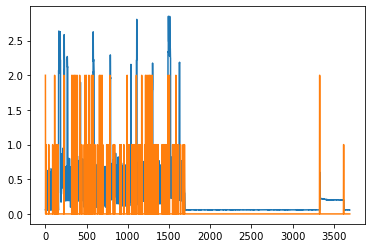

In [83]:
result[0].plot()
# result['true'].plot()
result['pred'].plot()

<ipython-input-76-a8997e45d2f9>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_pred2 = np.argmax(InceptionTime(torch.tensor(dataset2.tensors[0].to(device)).float()).cpu().detach(), axis=1)


0.5821167983316723
[[19900     3     1]
 [   37    11     0]
 [   36     0    12]]


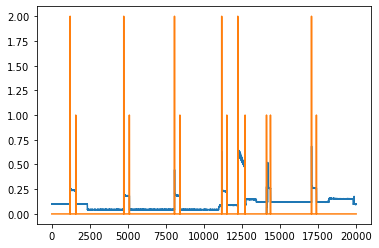

In [76]:
start=135000
end=155000
tensor_x2 = torch.Tensor(X_train_back[start:end]) # transform to torch tensor
tensor_y2 = torch.Tensor(y_train_back[start:end])
dataset2 = TensorDataset(tensor_x2,tensor_y2)

with torch.no_grad():
    x_pred2 = np.argmax(InceptionTime(torch.tensor(dataset2.tensors[0].to(device)).float()).cpu().detach(), axis=1)
    
y_true2=[]
for i in y_train_back[start:end]:
    if i[0]==1:
        y_true2.append(0)
    elif i[1]==1:
        y_true2.append(1)
    else:
        y_true2.append(2)
        
print(f1_score(y_true=y_true2, y_pred=x_pred2,average="macro"))
cf1 = confusion_matrix(y_true=y_true2, y_pred=x_pred2)
print(cf1)

result2=pd.DataFrame(X_train_back[start:end].reshape(len(X_train_back[start:end]),7))
result2['true']=y_true2
result2['pred']=x_pred2

result2[0].plot()
result2['pred'].plot()

In [66]:
X_train_back[100000:104000]

array([[[0.05 ],
        [0.049],
        [0.05 ],
        ...,
        [0.05 ],
        [0.049],
        [0.049]],

       [[0.049],
        [0.05 ],
        [0.05 ],
        ...,
        [0.049],
        [0.049],
        [0.051]],

       [[0.05 ],
        [0.05 ],
        [0.05 ],
        ...,
        [0.049],
        [0.051],
        [0.049]],

       ...,

       [[0.05 ],
        [0.049],
        [0.05 ],
        ...,
        [0.05 ],
        [0.05 ],
        [0.049]],

       [[0.049],
        [0.05 ],
        [0.049],
        ...,
        [0.05 ],
        [0.049],
        [0.051]],

       [[0.05 ],
        [0.049],
        [0.05 ],
        ...,
        [0.049],
        [0.051],
        [0.05 ]]])

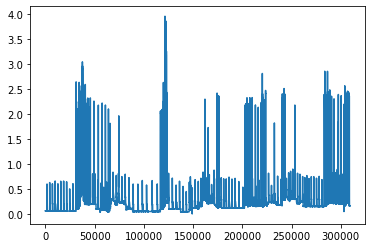

In [61]:
pd.DataFrame(X_train_back.reshape(len(X_train_back),7))[0].plot()